## Notebook setup


If TensorFlow complains about NUMA node reads from SysFs being -1, try running the following command:

`echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:01\:00.0/numa_node`

### Load Libraries

In [193]:
import os
import random

import ipyplot
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import applications as tfka

#### Setup TensorFlow

In [194]:
tf.get_logger().setLevel("INFO")
tf.autograph.set_verbosity(0)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # allow gpu memory growth

#### Initialize variables

In [195]:
SEED = 42
IMAGES_PATH = "data/images"
CHECKPOINT_PATH = "checkpoints"
MODEL_PATH = "models"
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)
INITIAL_LEARNING_RATE = 1e-4
MIN_LEARNING_RATE = 1e-7
EPOCHS = 10
FINE_TUNING_EPOCHS = 10

#### Set seeds

In [196]:
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#### Sanity Checks


In [197]:
assert os.path.exists(IMAGES_PATH), f"Images path {IMAGES_PATH} does not exist"
assert (
    VALIDATION_SPLIT + TEST_SPLIT < 1
), "Validation and test split should be less than 1"

if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
    print(f"Created checkpoint directory {CHECKPOINT_PATH}")
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print(f"Created model directory {MODEL_PATH}")

## Load Data

### Load data into datasets

In [198]:
def split_dataset(
    ds: tf.data.Dataset,
    test_split: float,
    validation_split: float,
) -> tuple[tf.data.Dataset]:
    ds_size = len(ds)
    test_size = int(ds_size * test_split)
    validation_size = int(ds_size * validation_split)
    train_size = ds_size - test_size - validation_size

    test_ds = ds.take(test_size)
    validation_ds = ds.skip(test_size).take(validation_size)
    train_ds = ds.skip(test_size + validation_size).take(train_size)
    return train_ds, validation_ds, test_ds


ds = tfk.utils.image_dataset_from_directory(
    IMAGES_PATH,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    verbose=False,
)

train_ds, validation_ds, test_ds = split_dataset(ds, TEST_SPLIT, VALIDATION_SPLIT)

print(f"Batch size: {BATCH_SIZE}")
print(
    f"Sizes (in batches): train = {len(train_ds)}, "
    f"validation = {len(validation_ds)}, test = {len(test_ds)}"
)
print(f"Classes: {ds.class_names}")


Batch size: 32
Sizes (in batches): train = 154, validation = 44, test = 22
Classes: ['glioma', 'healthy', 'meningioma', 'pituitary']


### Show some data


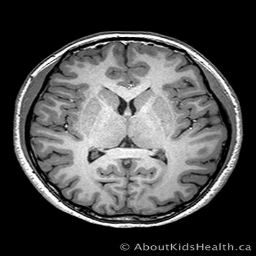
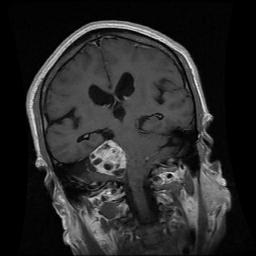
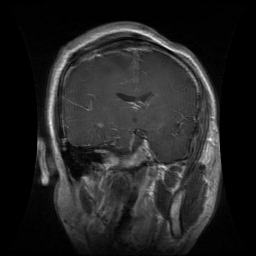
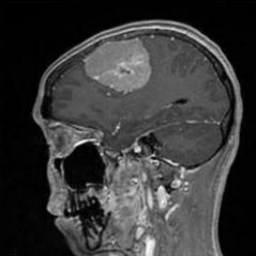
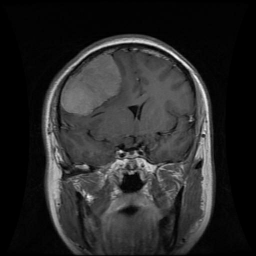
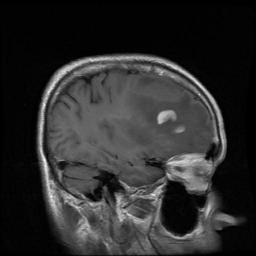
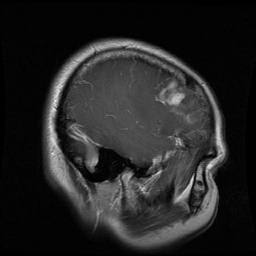
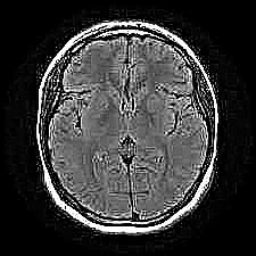
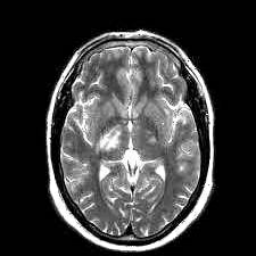
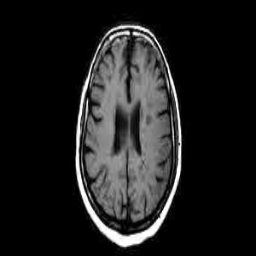
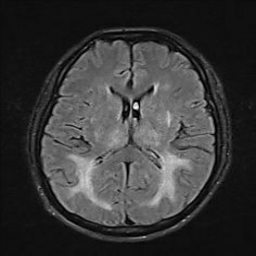
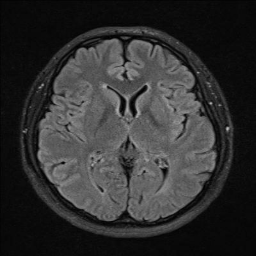
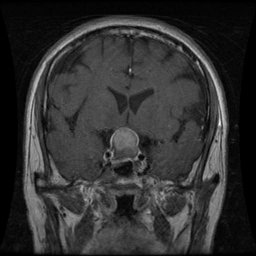
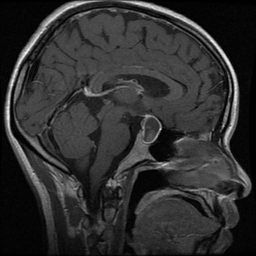
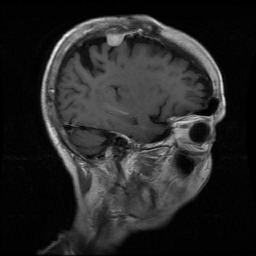
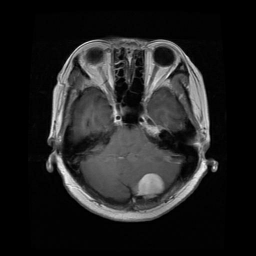
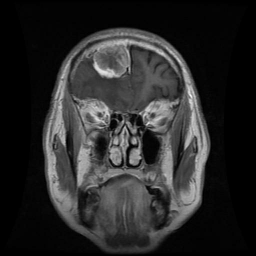
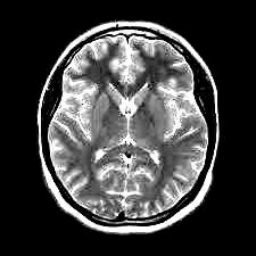
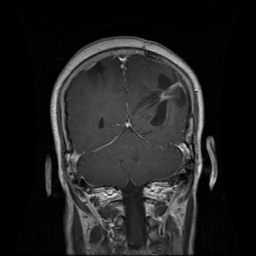
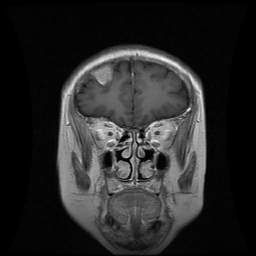
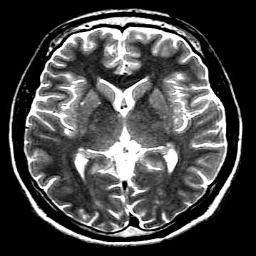
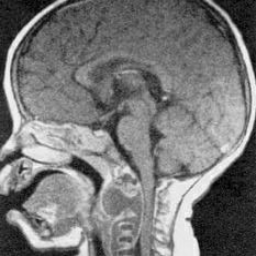
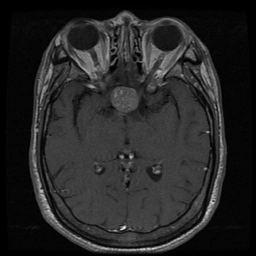
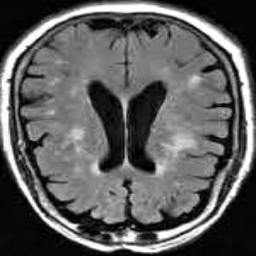
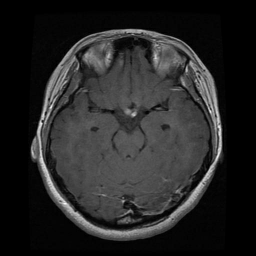


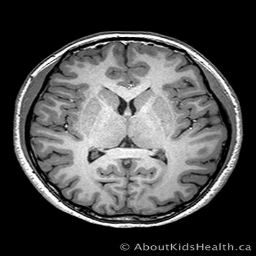
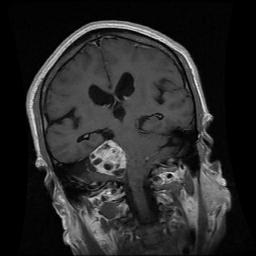
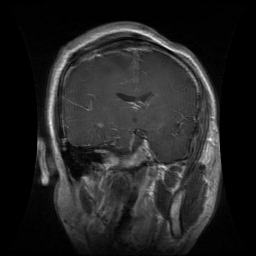
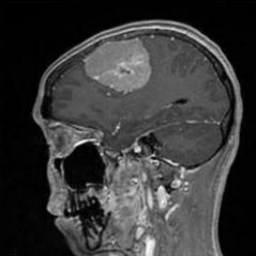
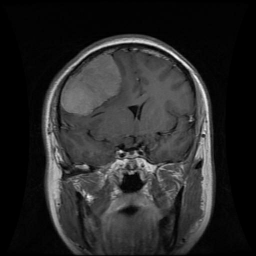
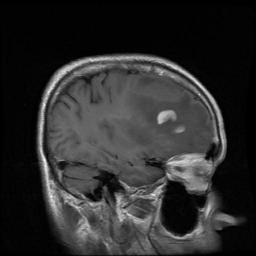
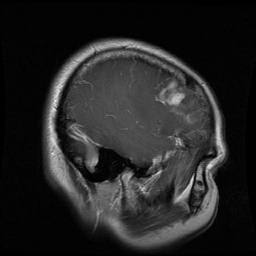
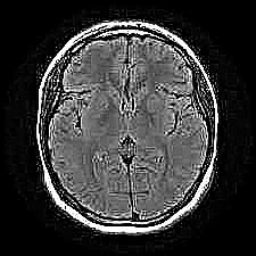
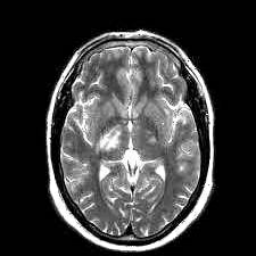
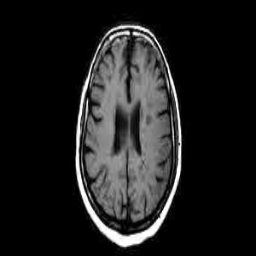
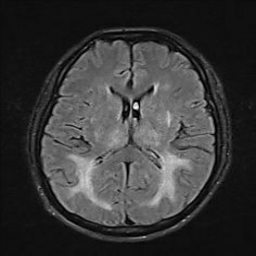
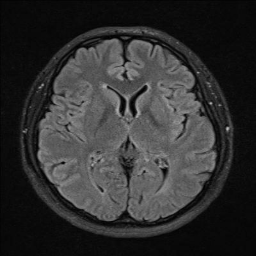
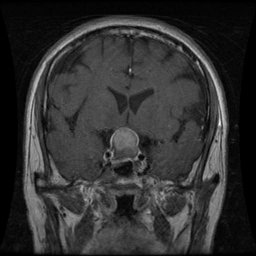
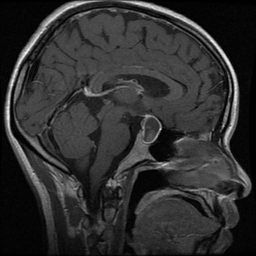
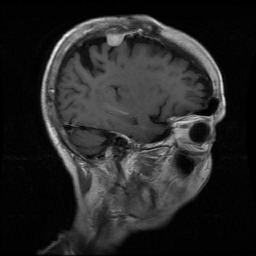
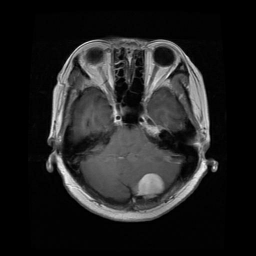
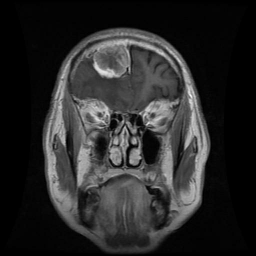
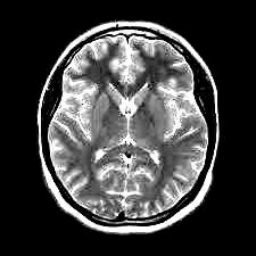
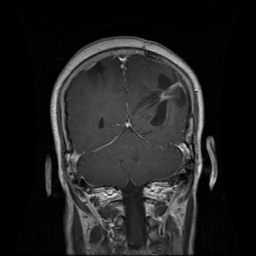
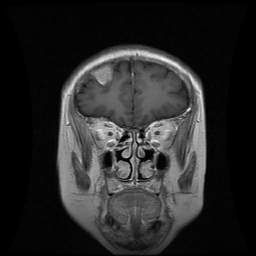
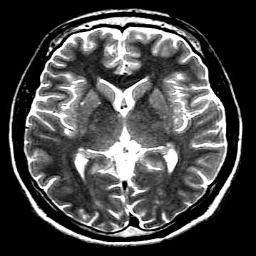
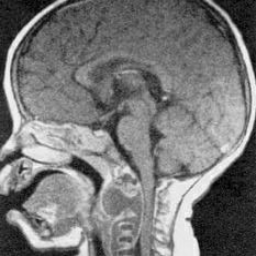
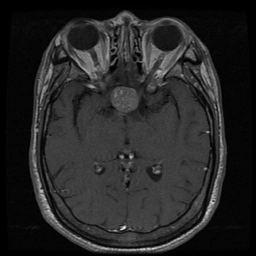
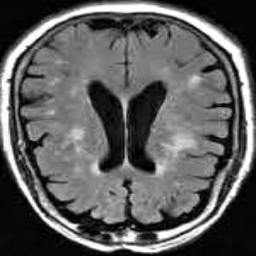
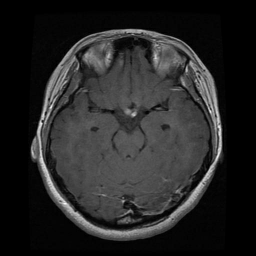

In [199]:
# extract some image from the test dataset
data = test_ds.take(1)
images, labels = next(iter(data))

# display the image
# image_array = np.array(image)
image_array = [np.array(image) for image in images]
labels = [ds.class_names[np.argmax(label)] for label in labels]
ipyplot.plot_images(image_array, labels, max_images=25, img_width=150)

### Show distribution of classes

Number of samples per class in the test dataset:
	glioma: 171
	healthy: 204
	meningioma: 158
	pituitary: 171


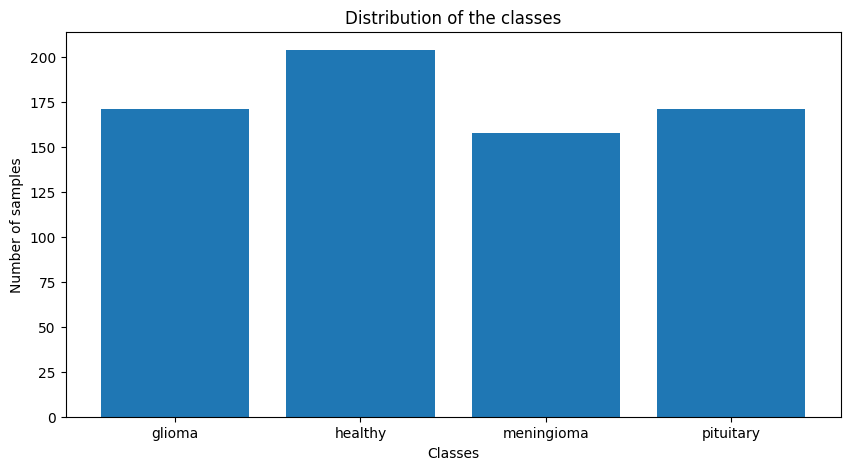

In [200]:
count = {c: 0 for c in ds.class_names}
for _, labels in test_ds:
    for label in labels:
        count[ds.class_names[np.argmax(label)]] += 1

print("Number of samples per class in the test dataset:")
for c, n in count.items():
    print(f"\t{c}: {n}")

# plot the distribution of the classes
plt.figure(figsize=(10, 5))
plt.bar(count.keys(), count.values())
plt.xlabel("Classes")
plt.ylabel("Number of samples")
plt.title("Distribution of the classes")
plt.show()

### Data Augmentation


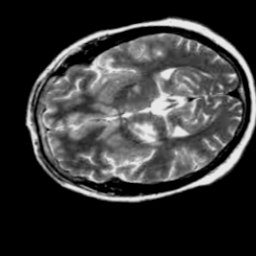
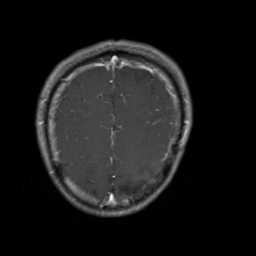
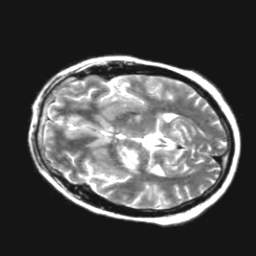
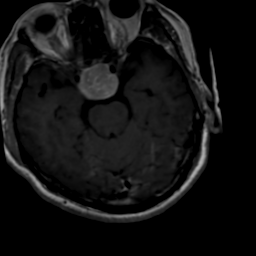
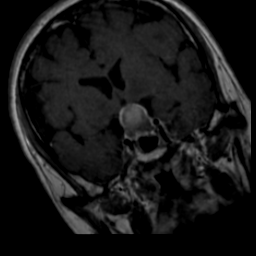
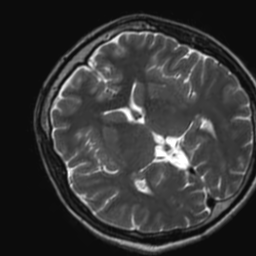
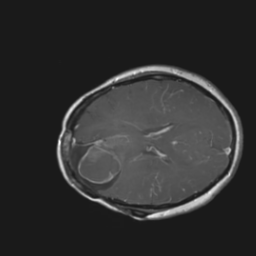
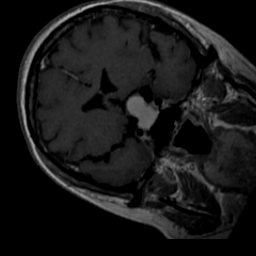
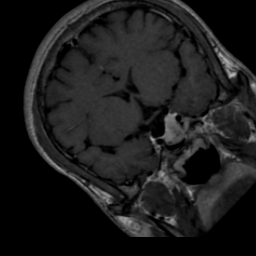
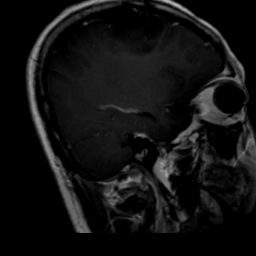
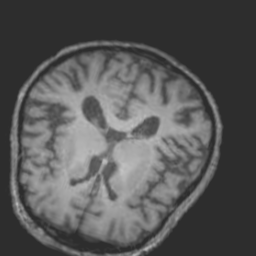
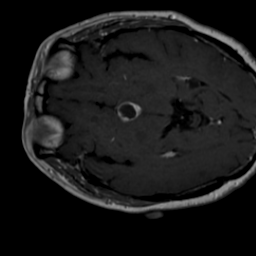
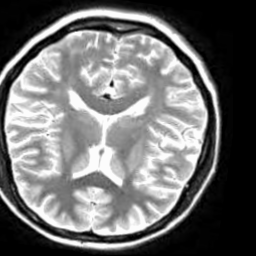
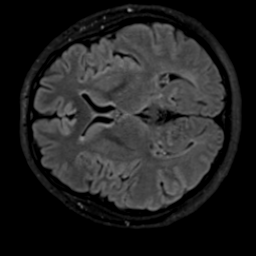
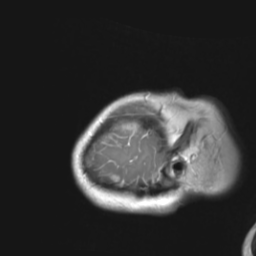
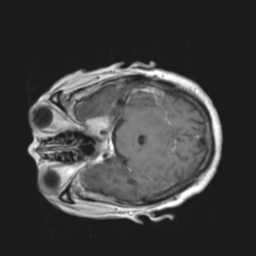
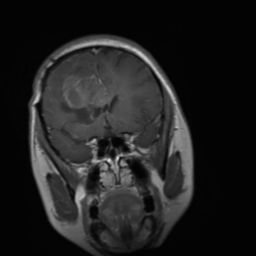
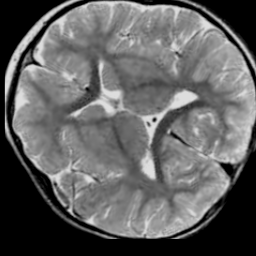
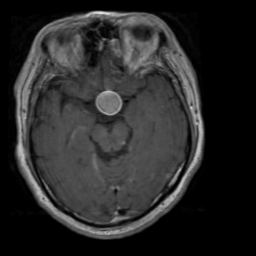
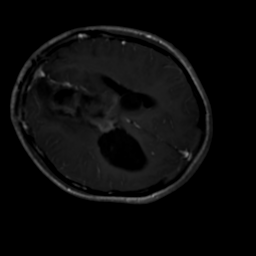
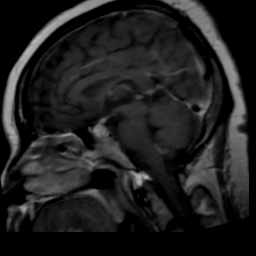
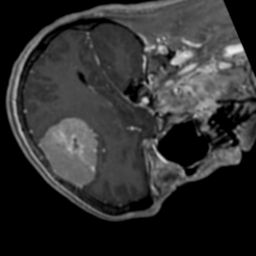
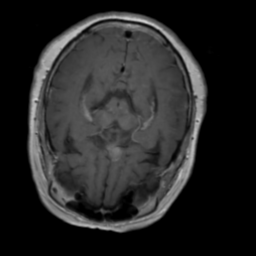
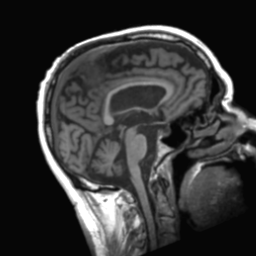
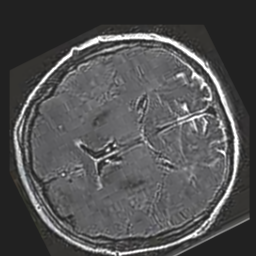


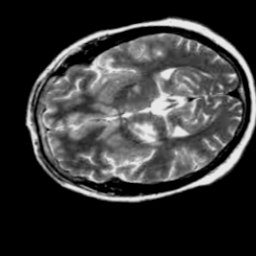
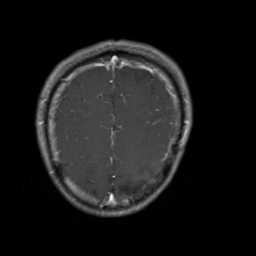
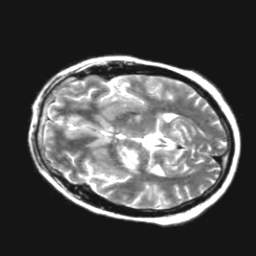
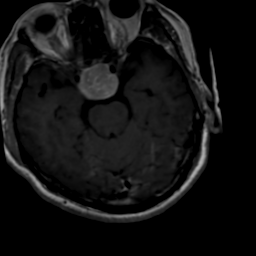
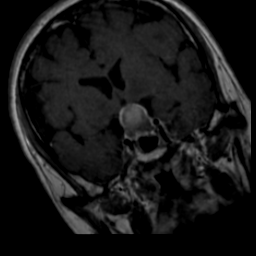
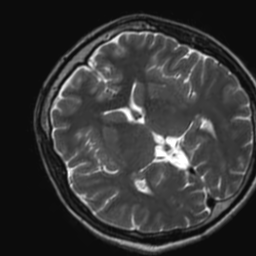
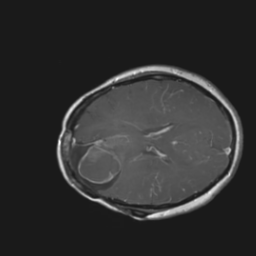
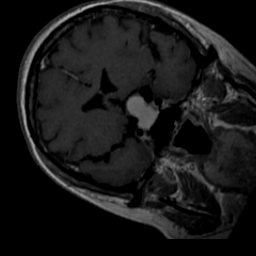
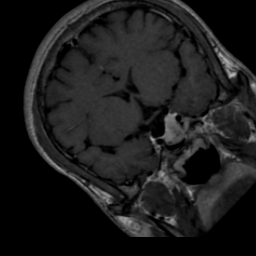
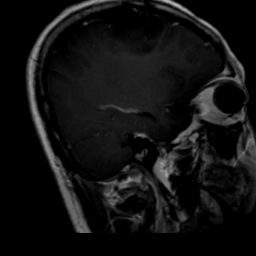
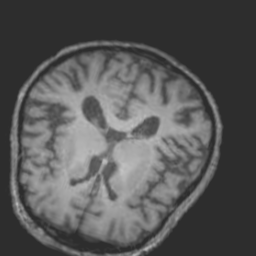
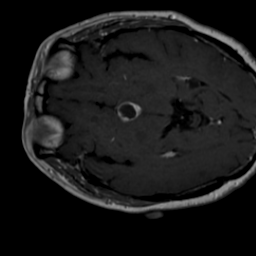
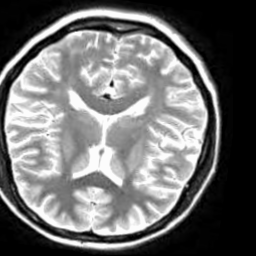
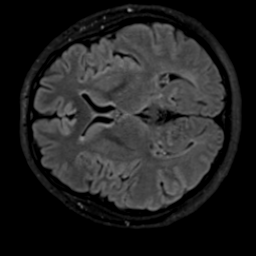
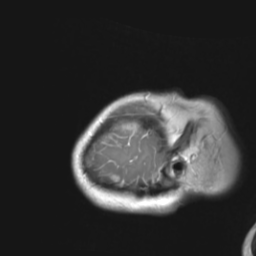
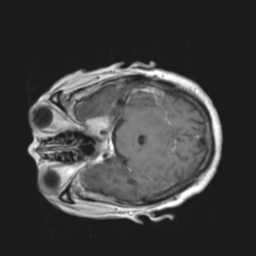
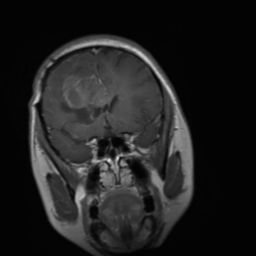
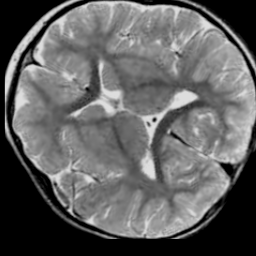
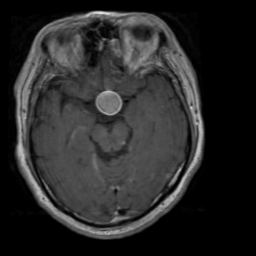
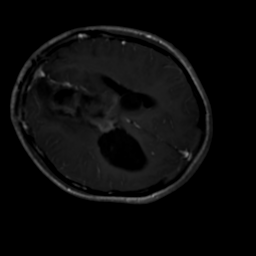
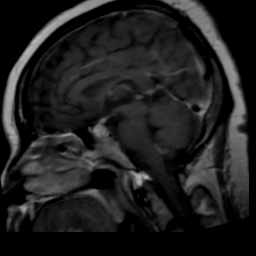
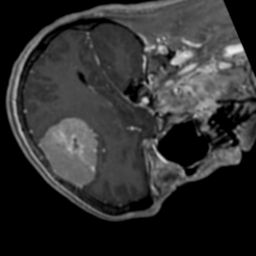
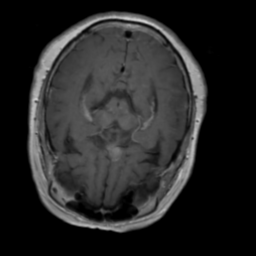
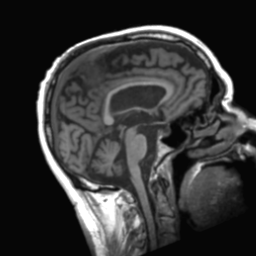
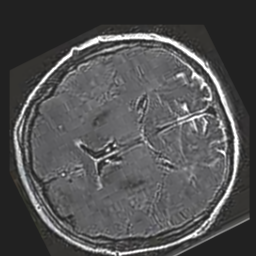

In [201]:
data_augmentation_layer = tfk.Sequential(
    [
        tfkl.Input(shape=INPUT_SHAPE),
        tfkl.RandomFlip(
            "horizontal_and_vertical",
            seed=SEED,
        ),
        tfkl.RandomRotation(
            0.5,
            fill_mode="constant",
            fill_value=0,
            seed=SEED,
        ),
        tfkl.RandomZoom(
            0.1,
            fill_mode="constant",
            fill_value=0,
            seed=SEED,
        ),
        tfkl.RandomTranslation(
            0.1,
            0.1,
            fill_mode="constant",
            fill_value=0,
            seed=SEED,
        ),
        tfkl.RandomContrast(
            0.2,
            seed=SEED,
        ),
        tfkl.RandomBrightness(
            0.2,
            seed=SEED,
        ),
    ]
)

# extract some images from the test dataset
data = test_ds.take(1)
images, labels = next(iter(data))

# apply data augmentation
augmented_images = data_augmentation_layer(images)

# display the augmented images
augmented_image_array = [np.array(image) for image in augmented_images]
labels = [ds.class_names[np.argmax(label)] for label in labels]

ipyplot.plot_images(augmented_image_array, labels, max_images=25, img_width=150)


## Define Model

- The approach I am going for is to use a pretrained model and fine-tune it for this dataset.
- [The keras documentation](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2l-function) shows the available models
  - I will use the [EfficientNetV2L model](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2l-function) as it has a good score and is not too heavy.

### Model Definition

In [202]:
# load the pretrained model
# there's no need for normalization layer since the model has it
resize_layer = tfkl.Resizing(*IMAGE_SIZE)
efficientnet_model = tfka.EfficientNetV2L(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    classes=len(ds.class_names),
)
efficientnet_model.trainable = False
# create input layer
inputs = tfkl.Input(shape=(*IMAGE_SIZE, 3))
# create data augmentation layer

# create an output network
output_layer = tfk.models.Sequential(
    [
        tfkl.GlobalAveragePooling2D(),
        tfkl.Dense(256, activation="relu"),
        tfkl.Dropout(0.5),
        tfkl.Dense(len(ds.class_names), activation="softmax"),
    ]
)


# create the model
x = inputs
x = resize_layer(x)
x = data_augmentation_layer(x)
x = efficientnet_model(x, training=False)
outputs = output_layer(x)

### Model summary

In [203]:
model = tfk.Model(inputs, outputs)
model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_6 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 8, 8, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 4)              │       328,964 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,075,812 (450.42 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

### Compile Model

In [204]:
def compile_model(model: tfk.Model) -> None:
    """Function to compile the model. Defined to be used later"""
    # compile the model
    model.compile(
        optimizer=tfk.optimizers.Adadelta(INITIAL_LEARNING_RATE),
        loss=tfk.losses.CategoricalCrossentropy(),
        metrics=[tfk.metrics.CategoricalAccuracy()],
    )


compile_model(model)


### Train the top layers

In [190]:
def fit_model(model: tfk.Model, epochs: int, filename: str = "model.keras") -> None:
    if not filename.endswith(".keras"):
        filename += ".keras"

    # create the early stopping callback
    early_stopping = tfk.callbacks.EarlyStopping(
        monitor="val_categorical_accuracy",
        patience=3,
        restore_best_weights=True,
    )
    # create the reudce learning rate on plateau callback
    reduce_lr = tfk.callbacks.ReduceLROnPlateau(
        monitor="val_categorical_accuracy",
        factor=0.1,
        patience=2,
        min_lr=MIN_LEARNING_RATE,
    )
    # create the model checkpoint callback
    checkpoint = tfk.callbacks.ModelCheckpoint(
        os.path.join(CHECKPOINT_PATH, filename),
        monitor="val_categorical_accuracy",
        save_best_only=True,
    )
    model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
    )


def save_model(model: tfk.Model, filename: str) -> None:
    if not filename.endswith(".keras"):
        filename += ".keras"
    model.save(os.path.join(MODEL_PATH, filename))


fit_model(model, EPOCHS, "train_top.keras")
save_model(model, "train_top.keras")


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - categorical_accuracy: 0.2385 - loss: 1.4376 - val_categorical_accuracy: 0.2514 - val_loss: 1.4339 - learning_rate: 1.0000e-04
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - categorical_accuracy: 0.2522 - loss: 1.4529 - val_categorical_accuracy: 0.2514 - val_loss: 1.4285 - learning_rate: 1.0000e-04
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - categorical_accuracy: 0.2351 - loss: 1.4482 - val_categorical_accuracy: 0.2528 - val_loss: 1.4276 - learning_rate: 1.0000e-04
Epoch 4/10
 80/154 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - categorical_accuracy: 0.2627 - loss: 1.4457

### Fine-tune the model

In [ ]:
efficientnet_model.trainable = True
compile_model(model)
fit_model(model, FINE_TUNING_EPOCHS, "fine_tuned.keras")
save_model(model, "fine_tuned.keras")